# Training the Semi-Supervised GAN for Melanoma Image Classification

**Objective**

   - Write a semi-supervised GAN for the image classification task and train it on the melanoma dataset (both labeled and unlabeled parts).



**Workflow**

 - Use the code from Milestone 2 to define datasets and dataloaders for the following: labeled and unlabeled training images, and labeled validation and test sets.

 - Start with an unsupervised DCGAN that would generate mole-like images and train it, e.g. on the unlabeled dataset. The goal is not to achieve the best results possible on the generation task, but rather to tune the hyperparameters to those which allow for generation of images roughly in the desired domain.


# 0. Mounting drive and declaring data sets

In [ ]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
import skimage
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import transforms, utils, models
from PIL import Image
import timeit                        # to evaluate elements of code
import time
import cv2
import tensorflow.compat.v1 as tf    # to avoid attributeError:
import random
import tensorflow_addons as tfa
import math
import sklearn.model_selection
from numba import cuda
import torchvision
from google.colab import drive       # to add data path
import copy
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class MelanomaDataset_unlab(Dataset):
    """melanoma detection dataset for unlabeled data set"""

    def __init__(self, images_dir, transform = None, through = 'pil'):
        """
        Args:
            images_dir (string): directory with all the images.
            transform (callable, optional): optional transform to be applied
                on a sample.
        """
        self.images_dir = images_dir
        self.transform = transform
        self.through = through

    def __len__(self):
        return len([i for i in os.listdir(self.images_dir) if '.jpg' in i])

    def __getitem__(self, idx):
        
        img_name = os.path.join(self.images_dir,
                                '{}.jpg'.format(str(idx)))
        through = self.through
        if through == 'skimage':
            image = io.imread(img_name)
        elif through == 'plt':
            image = plt.imread(img_name, format = 'jpg')
        elif through == 'pil':
            image = Image.open(img_name)
        elif through == 'cv':
            image = cv2.imread(img_name)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        else:
            raise NameError("name '{}' is not defined.".format(thro))
        sample = image
        if self.transform != None:
            sample = self.transform(sample)
        return sample

class MelanomaDataset_lab(Dataset):
    """melanoma detection dataset for labelled data"""

    def __init__(self, images_dir, transform = None, through = 'pil'):
        """
        Args:
            images_dir (string): directory with all the images.
            transform (callable, optional): optional transform to be applied
                on a sample.
        """
        self.images_dir = images_dir
        self.transform = transform
        self.through = through

    def __len__(self):
        return len([i for i in os.listdir(self.images_dir) if '.jpg' in i])

    def __getitem__(self, idx):
        through = self.through
        try:
            img_name = os.path.join(self.images_dir,
                                    '{}_1.jpg'.format(str(idx)));\
            label = 1
            through = self.through
            if through == 'skimage':
                image = io.imread(img_name)
            elif through == 'plt':
                image = plt.imread(img_name, format = 'jpg')
            elif through == 'pil':
                image = Image.open(img_name)
            elif through == 'cv':
                image = cv2.imread(img_name)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            else:
                raise NameError("name '{}' is not defined.".format(thro))
        except:
            img_name = os.path.join(self.images_dir,
                                    '{}_0.jpg'.format(str(idx)));
            label = 0
            if through == 'skimage':
                image = io.imread(img_name)
            elif through == 'plt':
                image = plt.imread(img_name, format = 'jpg')
            elif through == 'pil':
                image = Image.open(img_name)
            elif through == 'cv':
                image = cv2.imread(img_name)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            else:
                raise NameError("name '{}' is not defined.".format(thro))
        sample = image
        if self.transform != None:
            sample = self.transform(sample)
        return sample, label

In [ ]:
class Rot_90_torch(object):
    """Rotate the object anticlockwise 
    by random number times 90 degree"""
    def __init__(self):
        r = np.linspace(-2, 2, 5)    # all possible rotations by 90 degree
        k = random.choice(r)
        self.no = int(k)
    def __call__(self, img):
        tr = transforms.RandomRotation((self.no*90, self.no*90))
        return tr(img)

class Rot(object):
    """Flip the object with respect to first dimension."""
    def _largest_rotated_rect(self, w, h):
        """
        Given a rectangle of size w x h that has been rotated by 'angle' (in
        radians), computes the width and height of the largest possible
        axis-aligned rectangle within the rotated rectangle.
        Original JS code by 'Andri' and Magnus Hoff from Stack Overflow
        Converted to Python by Aaron Snoswell
        Source: http://stackoverflow.com/questions/16702966/rotate-image-and-crop-out-black-borders
        """
        angle = math.radians(15)
        quadrant = int(math.floor(angle / (math.pi / 2))) & 3
        sign_alpha = angle if ((quadrant & 1) == 0) else math.pi - angle
        alpha = (sign_alpha % math.pi + math.pi) % math.pi

        bb_w = w * math.cos(alpha) + h * math.sin(alpha)
        bb_h = w * math.sin(alpha) + h * math.cos(alpha)

        gamma = math.atan2(bb_w, bb_w) if (w < h) else math.atan2(bb_w, bb_w)

        delta = math.pi - alpha - gamma

        length = h if (w < h) else w

        d = length * math.cos(alpha)
        a = d * math.sin(alpha) / math.sin(delta)

        y = a * math.cos(gamma)
        x = y * math.tan(gamma)

        return (
            bb_w - 2 * x,
            bb_h - 2 * y
        )
    def __call__(self, img):
        tr_0 = transforms.Resize(32)
        tr_1 = transforms.RandomRotation((-15, 15), resample = Image.NEAREST)
        img = tr_1(img)
        lrr_width, lrr_height = self._largest_rotated_rect(32, 32)
        tr_2 = transforms.CenterCrop((lrr_height,lrr_width))  
        img = tr_0(tr_2(img))
        return img

In [ ]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA_PATH = "/content/drive/My Drive/Melanoma_dataset/"

In [ ]:
!ls "$DATA_PATH"

labeled						  second_model_batch_size_16.pt
second_attempt_resnet_18.pt			  second_model.pt
second_attempt_vgg11.pt				  test
second_model_batch_size_16_normalised_samples.pt  unlabeled


In [ ]:
augmentation = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(), 
                                   transforms.Resize(36), transforms.RandomCrop(32), Rot_90_torch(), Rot(), transforms.ToTensor()])
unlabeled_set = MelanomaDataset_unlab("/content/drive/My Drive/Melanoma_dataset/unlabeled", transform = augmentation)
labeled_set = MelanomaDataset_lab("/content/drive/My Drive/Melanoma_dataset/labeled/", transform = augmentation)
test_set = MelanomaDataset_lab("/content/drive/My Drive/Melanoma_dataset/test", transform = transforms.ToTensor())

print('Number of TEST images: ', len(test_set))
print('Number of LABELED images: ', len(labeled_set))
print('Number of UNLABELED images: ', len(unlabeled_set))

Number of TEST images:  600
Number of LABELED images:  200
Number of UNLABELED images:  7018


## 0.1. Adding normalisation

Normalisation of images:

In [ ]:
norm_1 = DataLoader(labeled_set, batch_size = 12, shuffle = False, num_workers = 16)
nimages = 0
mean = 0.
std = 0.
for batch, _ in norm_1:
    # Rearrange batch to be the shape of [B, C, W * H]
    batch = batch.view(batch.size(0), batch.size(1), -1)
    # Update total number of images
    nimages += batch.size(0)
    # Compute mean and std here
    mean += batch.mean(2).sum(0) 
    std += batch.std(2).sum(0)

# Final step
mean /= nimages
std /= nimages

print('Mean of images in labeled dataset: ', mean)
print('Standard deviation of images in labeled dataset: ', std)

normalization_l = transforms.Normalize(mean, std)

Mean of images in labeled dataset:  tensor([0.7119, 0.4804, 0.4930])
Standard deviation of images in labeled dataset:  tensor([0.1019, 0.1320, 0.1446])


In [ ]:
norm = DataLoader(unlabeled_set, batch_size = 128, shuffle = False, num_workers = 16)
nimages = 0
mean = 0.
std = 0.
for batch in norm:
    # Rearrange batch to be the shape of [B, C, W * H]
    batch = batch.view(batch.size(0), batch.size(1), -1)
    # Update total number of images
    nimages += batch.size(0)
    # Compute mean and std here
    mean += batch.mean(2).sum(0) 
    std += batch.std(2).sum(0)

# Final step
mean /= nimages
std /= nimages

print('Mean of images in unlabeled dataset: ', mean)
print('Standard deviation of images in unlabeled dataset: ', std)

normalization_unl = transforms.Normalize(mean, std)

Mean of images in unlabeled dataset:  tensor([0.7420, 0.4791, 0.4936])
Standard deviation of images in unlabeled dataset:  tensor([0.0969, 0.1264, 0.1382])


In [ ]:
augmentation_unl = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(), transforms.Resize(36), transforms.RandomCrop(32), Rot_90_torch(), Rot(), transforms.ToTensor(), normalization_unl])
augmentation_l = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(), transforms.Resize(36), transforms.RandomCrop(32), Rot_90_torch(), Rot(), transforms.ToTensor(), normalization_l])

In [ ]:
unlabeled_set_n = MelanomaDataset_unlab("/content/drive/My Drive/Melanoma_dataset/unlabeled", transform = augmentation_unl)
labeled_set_n = MelanomaDataset_lab("/content/drive/My Drive/Melanoma_dataset/labeled/", transform = augmentation_l)

 Labeled training and valuation images:

In [ ]:
# unnormalised sets
X_train_lab, X_val_lab = torch.utils.data.random_split(labeled_set, [170, 30])
X_train_unlab = unlabeled_set

# normalised sets
X_train_lab_n, X_val_lab_n = torch.utils.data.random_split(labeled_set_n, [170, 30])
X_train_unlab_n = unlabeled_set_n

X_test = test_set

# unnormalised images loaders
unlabeled_loader = DataLoader(X_train_unlab, batch_size=256, shuffle=True, num_workers=10)
labeled_loader = DataLoader(X_train_lab, batch_size=len(X_train_lab), shuffle=False, num_workers=1)
val_loader = DataLoader(X_val_lab, batch_size=len(X_val_lab), shuffle=False, num_workers=1)

test_loader = DataLoader(X_test, batch_size=len(X_test), shuffle=False, num_workers=1)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Since we only have one batch of labeled data, we might as well get it in
# the form of a PyTorch tensor now:
labeled_batch = next(iter(labeled_loader))
labeled_data = labeled_batch[0].to(device)
labels = labeled_batch[1].to(device)

# 2. Training unsupervised GAN on unnormalised data

Epoch  1


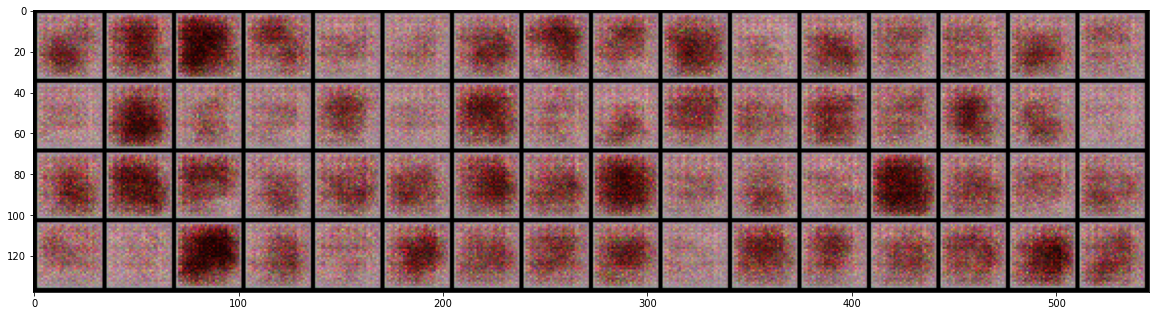

Epoch  10


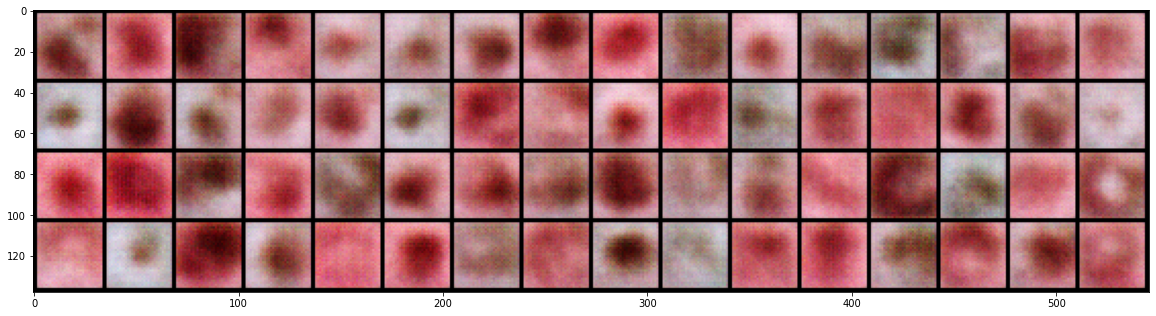

Epoch  20


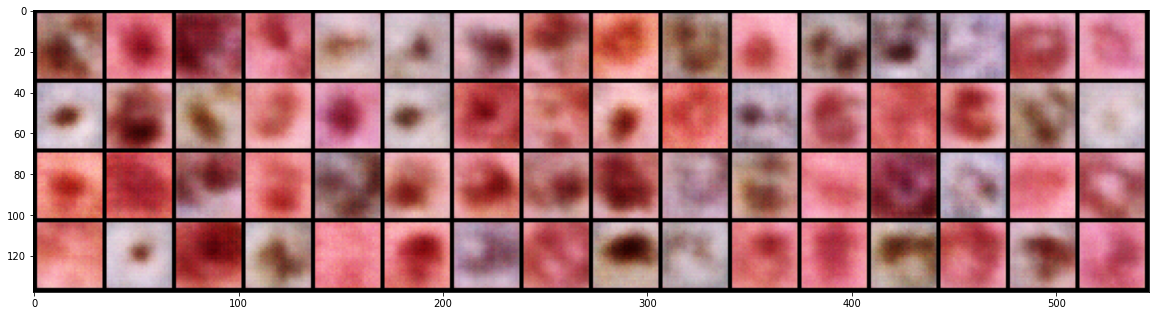

Epoch  30


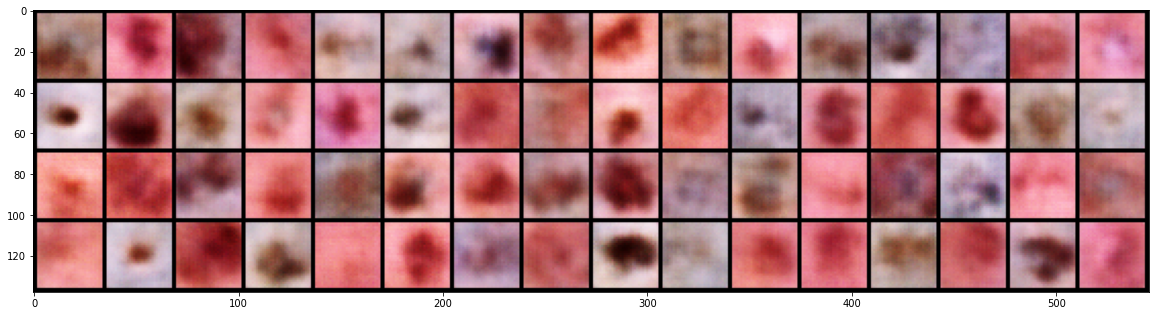

Epoch  40


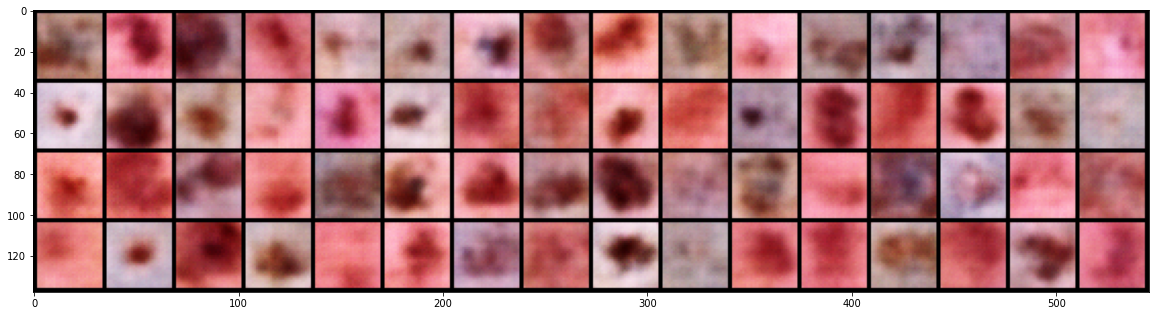

Epoch  50


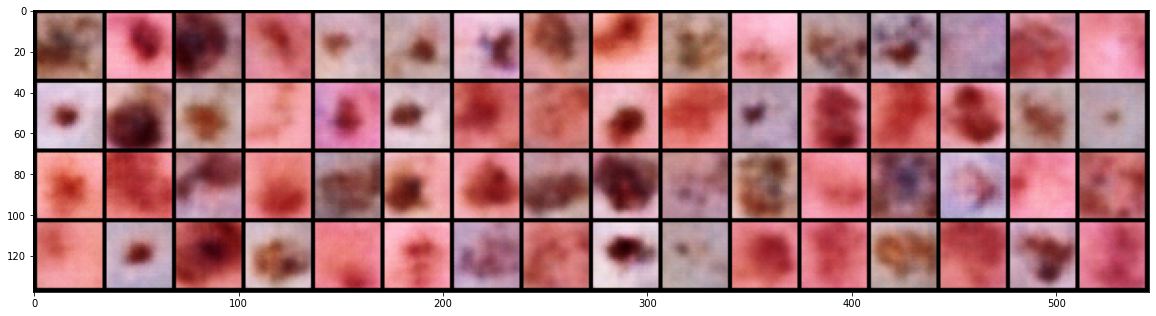

In [ ]:
# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.3

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
# Generator Code

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 32 x 32
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # state size. (ndf) x 32 x 32
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
    
# Create the generator
netG = Generator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Create the Discriminator
netD = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Training Loop
for epoch in range(1, 51):
    # For each batch in the dataloader
    for i, data in enumerate(unlabeled_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype = torch.float32, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = (netG(noise)+1.0)/2.0
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()


    if epoch % 10 == 0 or epoch == 1:
      with torch.no_grad():
          generated = (netG(fixed_noise).detach().cpu()+1.0)/2.0
          image_grid = torchvision.utils.make_grid(generated, normalize=True, nrow=16)
      
          print("Epoch ", epoch)
          plt.figure(figsize=(20,10))
          plt.imshow(image_grid.permute(1, 2, 0))
          plt.pause(0.05)

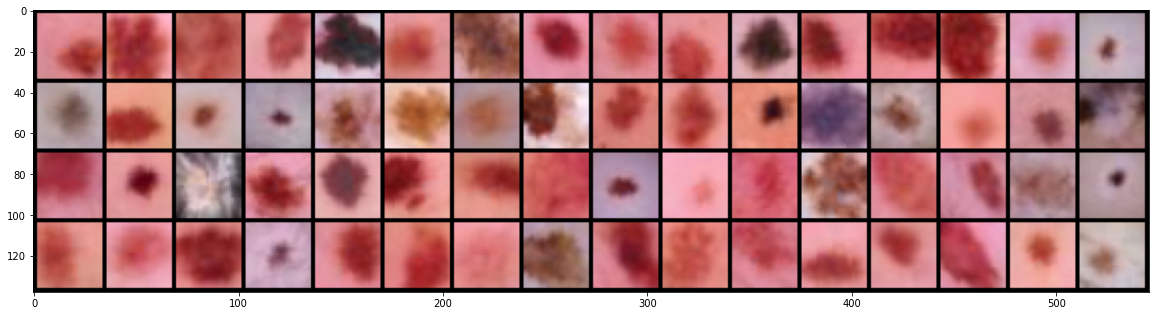

In [ ]:
image_grid = torchvision.utils.make_grid(data[:64,:,:,:], normalize=True, nrow=16)
plt.figure(figsize=(20,10))
plt.imshow(image_grid.permute(1, 2, 0))

# 3. Training unsupervised GAN on normalised data

In [ ]:
# normalised images loaders
unlabeled_loader_n = DataLoader(X_train_unlab_n, batch_size=256, shuffle=True, num_workers=10)
labeled_loader_n = DataLoader(X_train_lab_n, batch_size=len(X_train_lab_n), shuffle=False, num_workers=1)
val_loader_n = DataLoader(X_val_lab_n, batch_size=len(X_val_lab_n), shuffle=False, num_workers=1)

labeled_batch_n = next(iter(labeled_loader_n))
labeled_data_n = labeled_batch_n[0].to(device)
labels_n = labeled_batch_n[1].to(device)

Epoch  1


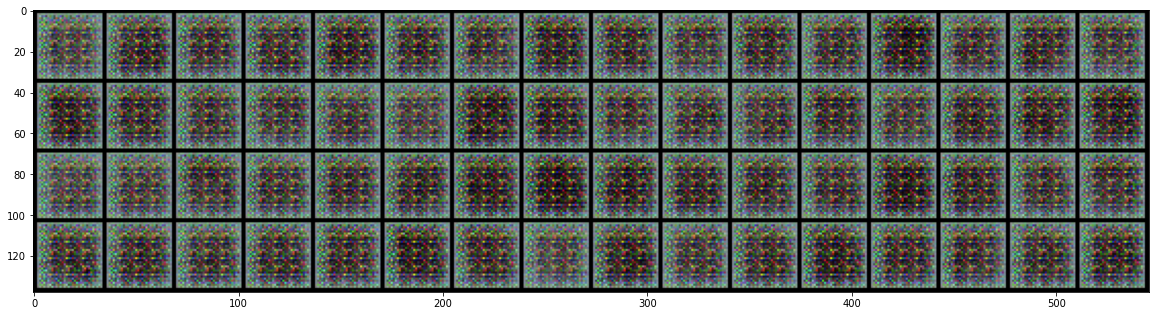

Epoch  10


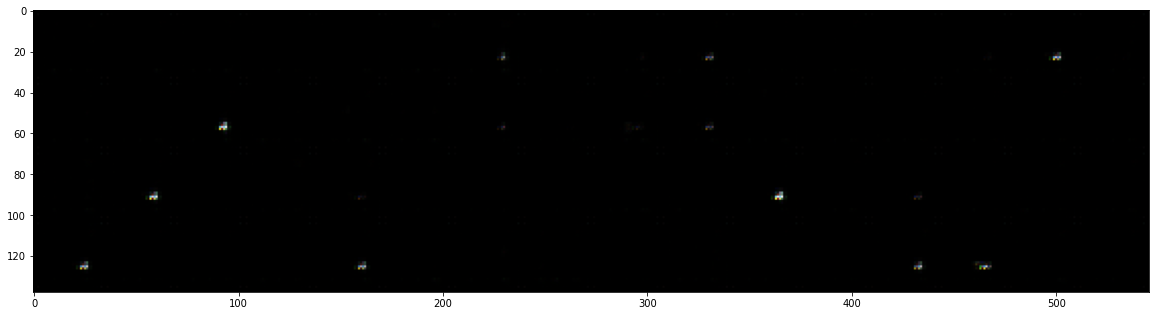

Epoch  20


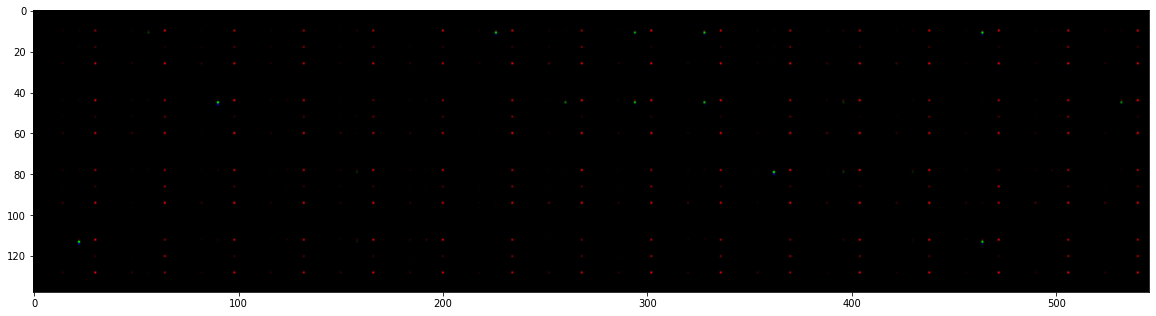

Epoch  30


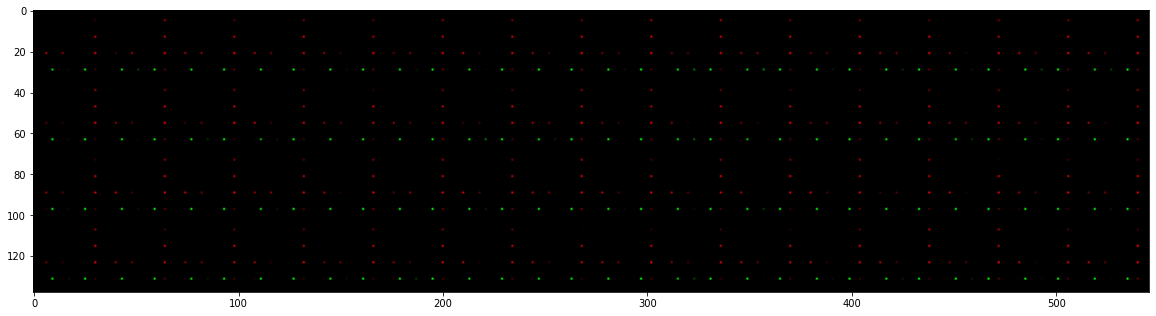

Epoch  40


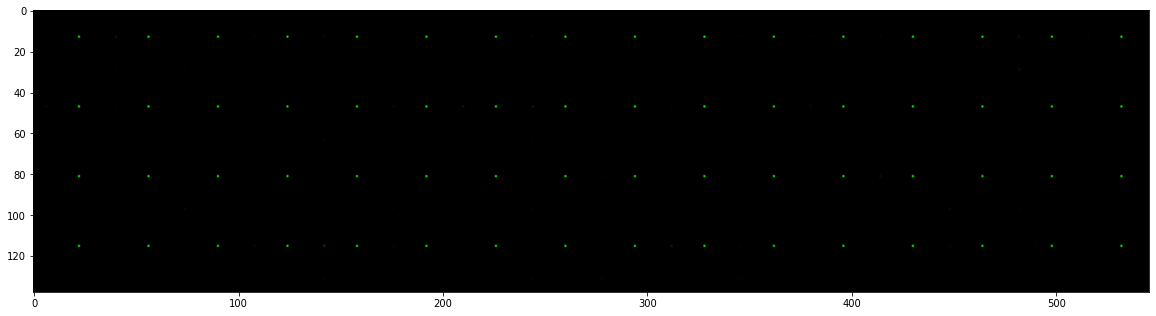

Epoch  50


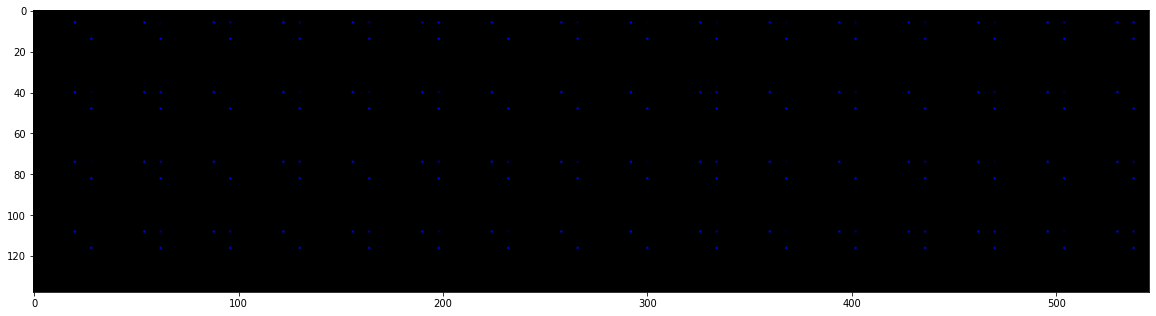

In [ ]:
# Create the generator
netG_n = Generator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG_n.apply(weights_init)

# Create the Discriminator
netD_n = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD_n.apply(weights_init)

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD_n = torch.optim.Adam(netD_n.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG_n = torch.optim.Adam(netG_n.parameters(), lr=lr, betas=(beta1, 0.999))

# Training Loop
for epoch in range(1, 51):
    # For each batch in the dataloader
    for i, data in enumerate(unlabeled_loader_n, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD_n.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype = torch.float32, device=device)
        # Forward pass real batch through D
        output = netD_n(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = (netG_n(noise)+1.0)/2.0
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD_n(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD_n.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG_n.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD_n(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG_n.step()


    if epoch % 10 == 0 or epoch == 1:
      with torch.no_grad():
          generated = (netG_n(fixed_noise).detach().cpu()+1.0)/2.0
          image_grid = torchvision.utils.make_grid(generated, normalize = True, nrow=16)
      
          print("Epoch ", epoch)
          plt.figure(figsize=(20,10))
          plt.imshow(image_grid.permute(1, 2, 0))
          plt.pause(0.05)

# 2. Semi-supervised GAN out of the DCGAN (unnormalised data)

In [ ]:
num_classes = 2

class Classifier(nn.Module):
    def __init__(self, n_classes):
        super(Classifier, self).__init__()
        self.main = nn.Sequential(
            # state size. (ndc) x 32 x 32
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, n_classes, 4, 1, 0, bias=False),
        )
    def forward(self, input):
        return self.main(input)
    
def log_sum_exp(x, axis = 1):
    m = torch.max(x, dim = 1)[0]
    return m + torch.log(torch.sum(torch.exp(x - m.unsqueeze(1)), dim = axis))

criterion = nn.CrossEntropyLoss()

def test(model, device, test_loader, display=False):
    
    # eval() is the mode that "turns off" the non-deterministic layers
    # that may be present in the model (e.g. dropout, batchnorm, etc)
    model.eval()
    
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.type(torch.LongTensor).to(device)
            output = model(data)
            test_loss += criterion(output.squeeze(), target.squeeze()).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)  
    
    if display:
        print('Test set accuracy: ',(100. * correct / len(test_loader.dataset)))
    
    return test_loss, (100. * correct / len(test_loader.dataset))
        
def train_SSL_GAN(generator, classifier, unlabeled_loader, labeled_data, labels, val_loader, device, 
                  optimizerG, optimizerC, epochs):

    val_losses = []
    val_accuracies = []

    best_model_wts = copy.deepcopy(classifier.state_dict())
    best_acc = 0.0

    for epoch in range(1, epochs + 1):

        for batch in unlabeled_loader:
        
            # TRAIN THE DISCRIMINATOR (THE CLASSIFIER)
            classifier.train()
            optimizerC.zero_grad()
        
            # 1. on Unlabelled data
            data = batch.to(device)
            outputs = classifier(data)    
            logz_unlabel = log_sum_exp(outputs)
            lossUL = 0.5 * (-torch.mean(logz_unlabel) + torch.mean(F.softplus(logz_unlabel)))
            lossUL.backward()  
        
            # 2. on the generated data

            noise = torch.randn(batch.size(0), 100, 1, 1, device=device)
            generated = (netG(noise)+1.0)/2.0
            outputs = classifier(generated.detach()) # detach() because we are not training G here
            logz_fake = log_sum_exp(outputs)
            lossD = 0.5*torch.mean(F.softplus(logz_fake))
            lossD.backward()
        
            # 3. on labeled data
            output = classifier(labeled_data).squeeze()
            logz_label = log_sum_exp(output)
            prob_label = torch.gather(output, 1, labels.unsqueeze(1))
            labeled_loss = -torch.mean(prob_label) + torch.mean(logz_label)
            labeled_loss.backward()    

            optimizerC.step()
        
            # TRAIN THE GENERATOR
            netG.train()
            optimizerG.zero_grad()
        
            outputs = classifier(generated)
            logz_unlabel = log_sum_exp(outputs)
            lossG = 0.5 * (-torch.mean(logz_unlabel) + torch.mean(F.softplus(logz_unlabel)))
            lossG.backward()
            optimizerG.step()
        
            val_loss, val_accuracy = test(classifier, device, val_loader, False)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
        
            if val_accuracy > best_acc:
                best_acc = val_accuracy
                best_classifier_wts = copy.deepcopy(classifier.state_dict())
            
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('VAL loss', color=color)
    ax1.plot(range(len(np.array(val_losses))), np.array(val_losses), color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx() 

    color = 'tab:blue'
    ax2.set_ylabel('VAL accuracy', color=color)  
    ax2.plot(range(len(np.array(val_losses))), np.array(val_accuracies), color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  
    plt.show()
   
    print('Highest accuracy on the VAL set: ', np.max(val_accuracies))
        
    classifier.load_state_dict(best_classifier_wts)
    return classifier

In [ ]:
criterion = nn.CrossEntropyLoss()

def test(model, device, test_loader, display=False):
    
    # eval() is the mode that "turns off" the non-deterministic layers
    # that may be present in the model (e.g. dropout, batchnorm, etc)
    model.eval()
    
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.type(torch.LongTensor).to(device)
            output = model(data)
            test_loss += criterion(output.squeeze(), target.squeeze()).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)  
    
    if display:
        print('Test set accuracy: ',(100. * correct / len(test_loader.dataset)))
    
    return test_loss, (100. * correct / len(test_loader.dataset))

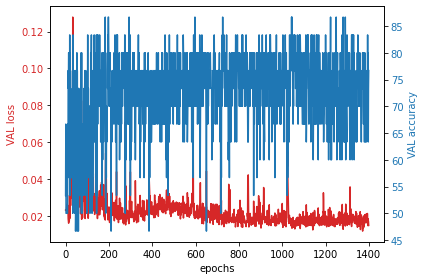

Highest accuracy on the VAL set:  86.66666666666667
Test set accuracy:  74.66666666666667


(0.0012648182113965353, 74.66666666666667)

In [ ]:
def set_seed(seed):

    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)

set_seed(1)

netG = Generator().to(device)
netG.apply(weights_init)

classifier = Classifier(n_classes=num_classes).to(device)
classifier.apply(weights_init)

optimizerG = optim.Adam(netG.parameters(), lr=lr, betas= (beta1, 0.999))
optimizerC = optim.Adam(classifier.parameters(), lr=lr, betas= (beta1, 0.999))
    
    
model = train_SSL_GAN(netG, classifier, unlabeled_loader, labeled_data, labels, 
                      val_loader, device, optimizerG, optimizerC, 50)

test(model, device, test_loader, True)

# 2.1 Semi-supervised GAN out of the DCGAN (normalised data)

In [ ]:
def test(model, device, test_loader, display=False):
    
    # eval() is the mode that "turns off" the non-deterministic layers
    # that may be present in the model (e.g. dropout, batchnorm, etc)
    model.eval()
    
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.type(torch.LongTensor).to(device)
            output = model(data)
            test_loss += criterion(output.squeeze(), target.squeeze()).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)  
    
    if display:
        print('Test set accuracy: ',(100. * correct / len(test_loader.dataset)))
    
    return test_loss, (100. * correct / len(test_loader.dataset))
        
def train_SSL_GAN(generator, classifier, unlabeled_loader_n, labeled_data_n, labels_n, val_loader_n, device, 
                  optimizerG, optimizerC, epochs):

    val_losses = []
    val_accuracies = []

    best_model_wts = copy.deepcopy(classifier.state_dict())
    best_acc = 0.0

    for epoch in range(1, epochs + 1):

        for batch in unlabeled_loader_n:
        
            # TRAIN THE DISCRIMINATOR (THE CLASSIFIER)
            classifier.train()
            optimizerC.zero_grad()
        
            # 1. on Unlabelled data
            data = batch.to(device)
            outputs = classifier(data)    
            logz_unlabel = log_sum_exp(outputs)
            lossUL = 0.5 * (-torch.mean(logz_unlabel) + torch.mean(F.softplus(logz_unlabel)))
            lossUL.backward()  
        
            # 2. on the generated data

            noise = torch.randn(batch.size(0), 100, 1, 1, device=device)
            generated = (netG(noise)+1.0)/2.0
            outputs = classifier(generated.detach()) # detach() because we are not training G here
            logz_fake = log_sum_exp(outputs)
            lossD = 0.5*torch.mean(F.softplus(logz_fake))
            lossD.backward()
        
            # 3. on labeled data
            output = classifier(labeled_data_n).squeeze()
            logz_label = log_sum_exp(output)
            prob_label = torch.gather(output, 1, labels_n.unsqueeze(1))
            labeled_loss = -torch.mean(prob_label) + torch.mean(logz_label)
            labeled_loss.backward()    

            optimizerC.step()
        
            # TRAIN THE GENERATOR
            netG.train()
            optimizerG.zero_grad()
        
            outputs = classifier(generated)
            logz_unlabel = log_sum_exp(outputs)
            lossG = 0.5 * (-torch.mean(logz_unlabel) + torch.mean(F.softplus(logz_unlabel)))
            lossG.backward()
            optimizerG.step()
        
            val_loss, val_accuracy = test(classifier, device, val_loader_n, False)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
        
            if val_accuracy > best_acc:
                best_acc = val_accuracy
                best_classifier_wts = copy.deepcopy(classifier.state_dict())
            
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('VAL loss', color=color)
    ax1.plot(range(len(np.array(val_losses))), np.array(val_losses), color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx() 

    color = 'tab:blue'
    ax2.set_ylabel('VAL accuracy', color=color)  
    ax2.plot(range(len(np.array(val_losses))), np.array(val_accuracies), color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  
    plt.show()
   
    print('Highest accuracy on the VAL set: ', np.max(val_accuracies))
        
    classifier.load_state_dict(best_classifier_wts)
    return classifier

In [ ]:
def test(model, device, test_loader, display=False):
    
    # eval() is the mode that "turns off" the non-deterministic layers
    # that may be present in the model (e.g. dropout, batchnorm, etc)
    model.eval()
    
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.type(torch.LongTensor).to(device)
            output = model(data)
            test_loss += criterion(output.squeeze(), target.squeeze()).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)  
    
    if display:
        print('Test set accuracy: ',(100. * correct / len(test_loader.dataset)))
    
    return test_loss, (100. * correct / len(test_loader.dataset))

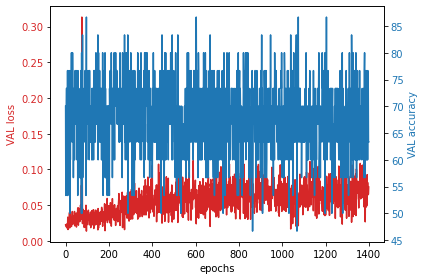

Highest accuracy on the VAL set:  86.66666666666667
Test set accuracy:  50.166666666666664


(0.002555006146430969, 50.166666666666664)

In [ ]:
def set_seed(seed):

    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)

set_seed(1)

netG = Generator().to(device)
netG.apply(weights_init)

classifier = Classifier(n_classes=num_classes).to(device)
classifier.apply(weights_init)

optimizerG = optim.Adam(netG.parameters(), lr=lr, betas= (beta1, 0.999))
optimizerC = optim.Adam(classifier.parameters(), lr=lr, betas= (beta1, 0.999))
    
    
model = train_SSL_GAN(netG, classifier, unlabeled_loader_n, labeled_data_n, labels_n, 
                      val_loader_n, device, optimizerG, optimizerC, 50)

test(model, device, test_loader, True)